Autor: Manuel Meniño Magán

Proyecto: 11MBIG TFM. Detección de anomalías en series temporales de tráfico de Internet. Aplicación en indicadores de red de Vodafone España

Descripción: En este cuaderno se realiza el análisis de datos exploratorio

In [ ]:
import requests
import io
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from google.colab import files
from google.colab import drive
import datetime
from datetime import datetime, timezone
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Importar datasets train y test a csv

Importar datasets previos

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cp '/gdrive/My Drive/11MBIG TFM/SID Data/train_inet_vigo_202007.csv' serie_train.csv
!cp '/gdrive/My Drive/11MBIG TFM/SID Data/test_inet_vigo_202007.csv' serie_test.csv
!ls -la | grep .csv

-rw------- 1 root root  59078 Oct  2 22:55 serie_test.csv
-rw------- 1 root root 236882 Oct  2 22:55 serie_train.csv


In [ ]:
serie_train = pd.read_csv('serie_train.csv', usecols=['timeStamp', 'total'])
serie_train.set_index(keys='timeStamp', inplace=True)
serie_test = pd.read_csv('serie_test.csv', usecols=['timeStamp', 'total'])
serie_test.set_index(keys='timeStamp', inplace=True)

In [ ]:
serie_test.head()

,total
timeStamp,
1595800800,55.256671
1595801100,55.490521
1595801400,53.201406
1595801700,52.884181
1595802000,52.357252


##Cambiar TimeStamp a Date

In [ ]:
serie_train.index = pd.to_datetime(serie_train.index, unit='s') + pd.Timedelta('02:00:00') #¡OJO! +2 por ser horario de verano. El timestamp está en horario UTC
serie_test.index = pd.to_datetime(serie_test.index, unit='s') + pd.Timedelta('02:00:00')
serie_test.head()

,total
timeStamp,
2020-07-27 00:00:00,55.256671
2020-07-27 00:05:00,55.490521
2020-07-27 00:10:00,53.201406
2020-07-27 00:15:00,52.884181
2020-07-27 00:20:00,52.357252


Variables temporales

In [ ]:
epoch_week27_start=1593381600
epoch_week28_start=1593986400
epoch_week29_start=1594591200
epoch_week30_start=1595196000
epoch_week31_start=1595800800
epoch_week32_start=1596405600
epoch_hour = 60*60
epoch_day = 24 * epoch_hour
epoch_week = 7 * epoch_day
day_samples = int(epoch_day/300)
week_samples = int(epoch_week/300)

##Añadir datos de semana, dia de la semana y hora

In [ ]:
serie_train['week'] = serie_train.index.weekofyear
serie_train['weekday'] = serie_train.index.weekday
serie_train['hour'] = serie_train.index.hour
serie_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.


,total,week,weekday,hour
timeStamp,,,,
2020-06-29 00:00:00,55.950883,27,0,0
2020-06-29 00:05:00,55.184399,27,0,0
2020-06-29 00:10:00,54.702931,27,0,0
2020-06-29 00:15:00,53.737060,27,0,0
2020-06-29 00:20:00,51.766890,27,0,0


In [ ]:
serie_test['week'] = serie_test.index.weekofyear
serie_test['weekday'] = serie_test.index.weekday
serie_test['hour'] = serie_test.index.hour
serie_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.


,total,week,weekday,hour
timeStamp,,,,
2020-07-27 00:00:00,55.256671,31,0,0
2020-07-27 00:05:00,55.490521,31,0,0
2020-07-27 00:10:00,53.201406,31,0,0
2020-07-27 00:15:00,52.884181,31,0,0
2020-07-27 00:20:00,52.357252,31,0,0


In [ ]:
serie_test.tail()

,total,week,weekday,hour
timeStamp,,,,
2020-08-02 23:35:00,59.931283,31,6,23
2020-08-02 23:40:00,58.796034,31,6,23
2020-08-02 23:45:00,58.127769,31,6,23
2020-08-02 23:50:00,58.340047,31,6,23
2020-08-02 23:55:00,58.463460,31,6,23


##EDA

Patrón de tráfico

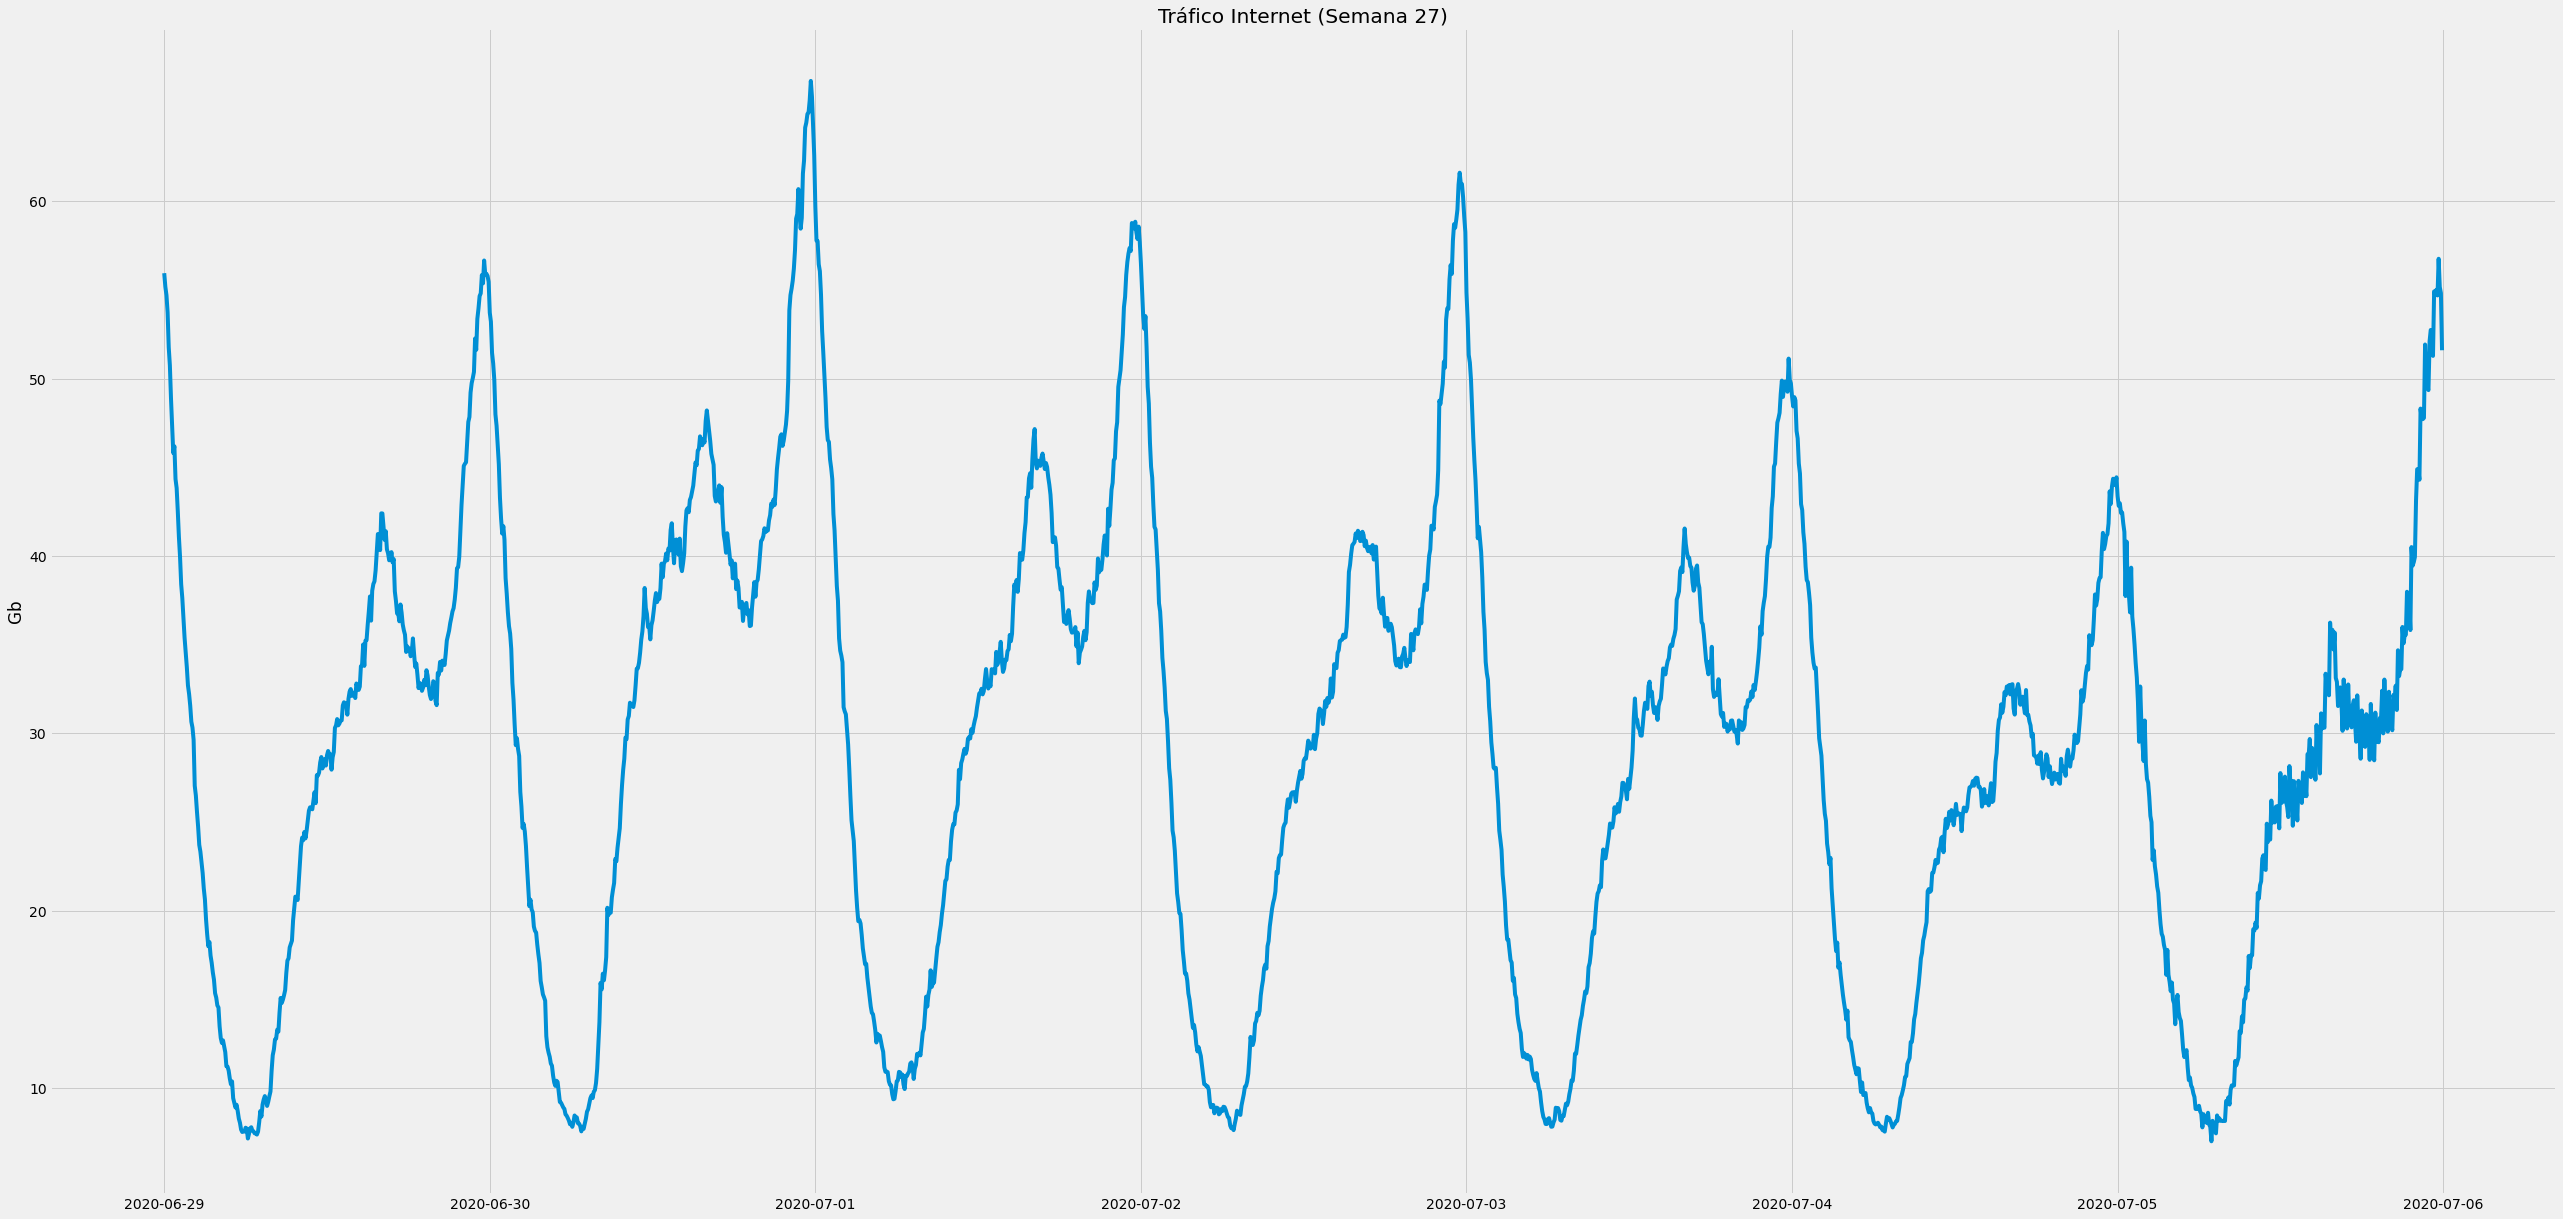

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,20])
plt.ylabel('Gb')
plt.title('Tráfico Internet (Semana 27)')
serie_train_w27 = serie_train[serie_train['week']==27]['total']
plt.plot(serie_train_w27)

Histograma

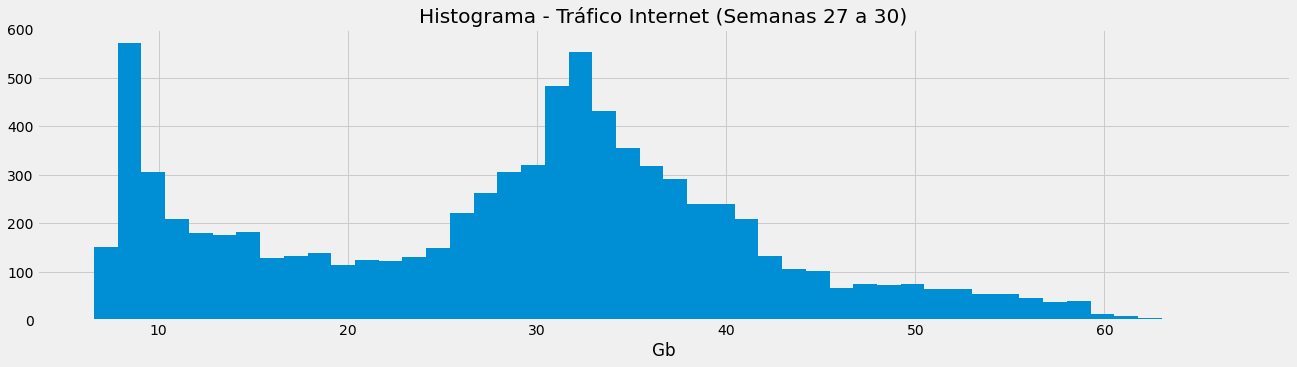

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[20,5])
plt.hist(serie_train['total'], bins=48)
plt.xlabel('Gb')
#plt.ylabel('#Muestras')
plt.title('Histograma - Tráfico Internet (Semanas 27 a 30)')
plt.show()

Boxplot

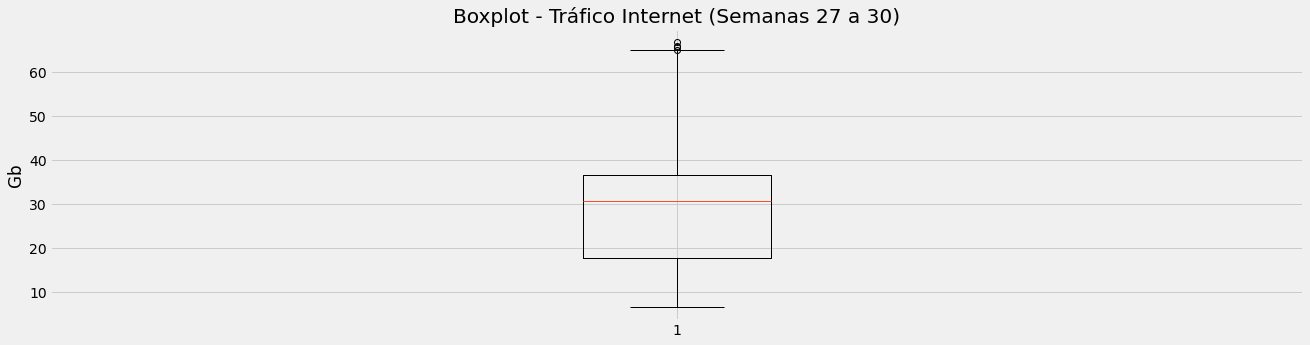

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[20,5])
plt.boxplot(serie_train['total'])
#plt.xlabel('')
plt.ylabel('Gb')
plt.title('Boxplot - Tráfico Internet (Semanas 27 a 30)')
plt.show()

https://towardsdatascience.com/time-series-analysis-using-pandas-in-python-f726d87a97d8


Text(0.5, 1.0, 'Boxplot - Tráfico Internet (Semanas 27 a 30)')

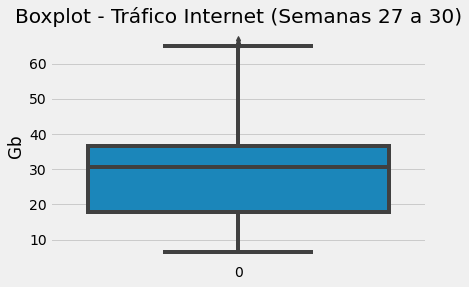

In [ ]:
sns.boxplot(data=serie_train['total'])
plt.ylabel('Gb')
plt.title('Boxplot - Tráfico Internet (Semanas 27 a 30)')

Text(0.5, 1.0, 'Boxplot - Tráfico Internet (Semanas 27 a 30) // Dia de la semana')

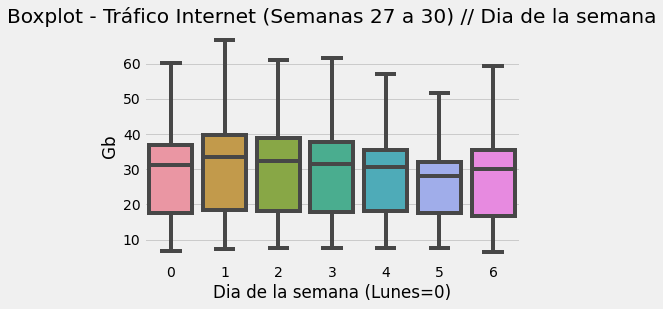

In [ ]:
sns.boxplot(data=serie_train, x='weekday', y='total')
plt.xlabel('Dia de la semana (Lunes=0)')
plt.ylabel('Gb')
plt.title('Boxplot - Tráfico Internet (Semanas 27 a 30) // Dia de la semana')

Text(0.5, 1.0, 'Boxplot - Tráfico Internet (Semanas 27 a 30) // Hora')

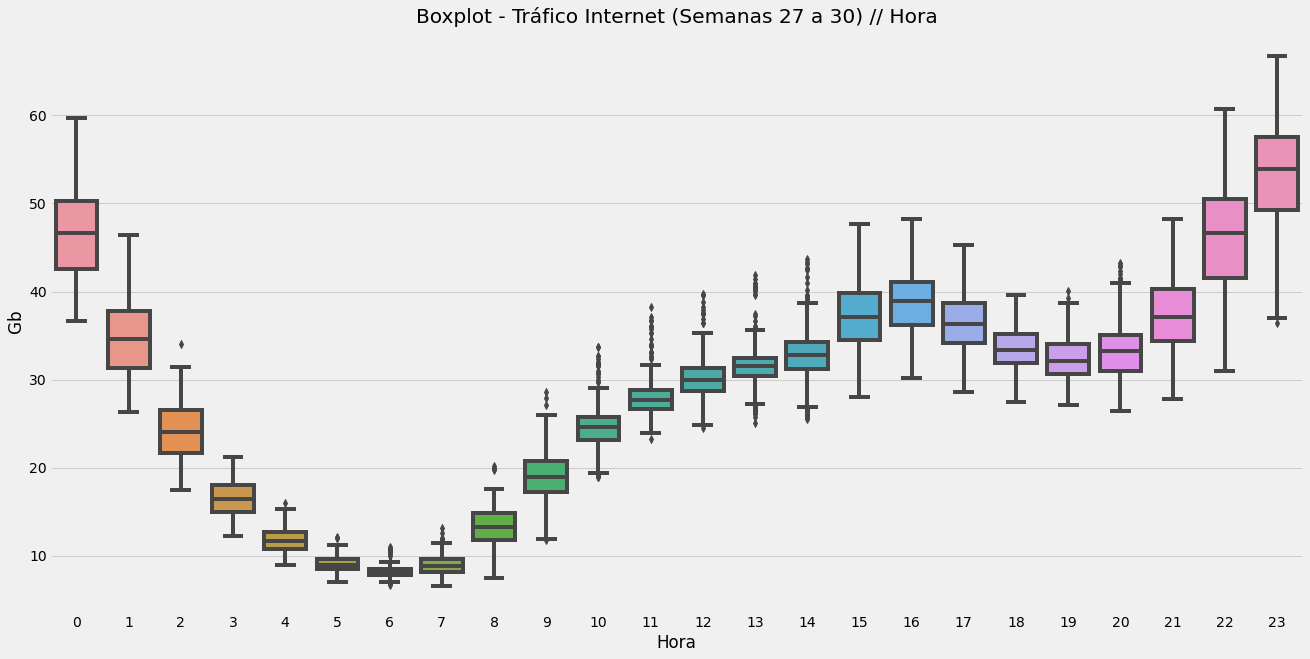

In [ ]:
plt.figure(figsize=[20,10])
sns.boxplot(data=serie_train, x='hour', y='total')
plt.xlabel('Hora')
plt.ylabel('Gb')
plt.title('Boxplot - Tráfico Internet (Semanas 27 a 30) // Hora')

##Autocorrelación

https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself.

A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.

day_samples = 288, week_samples = 2016

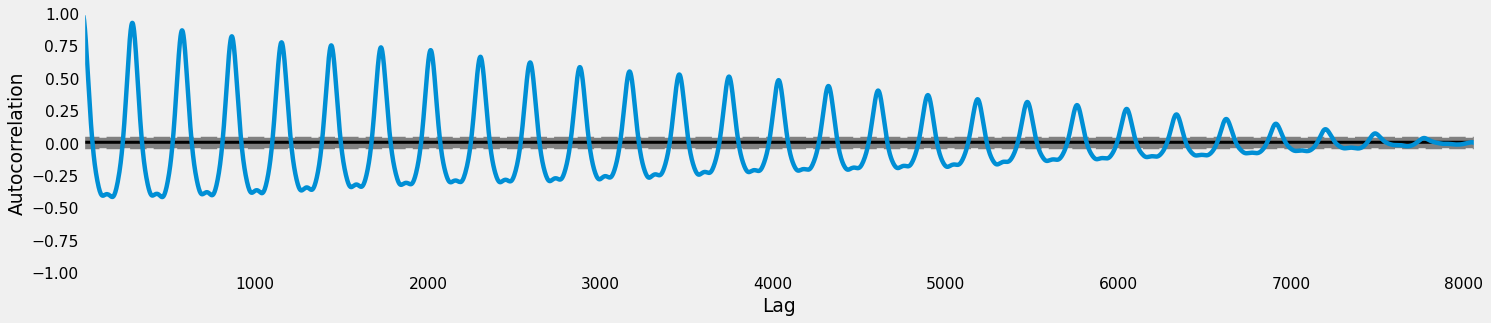

In [ ]:
plt.figure(figsize=(20,4), dpi= 80)
pd.plotting.autocorrelation_plot(serie_train['total']);
pd.plotting.pac

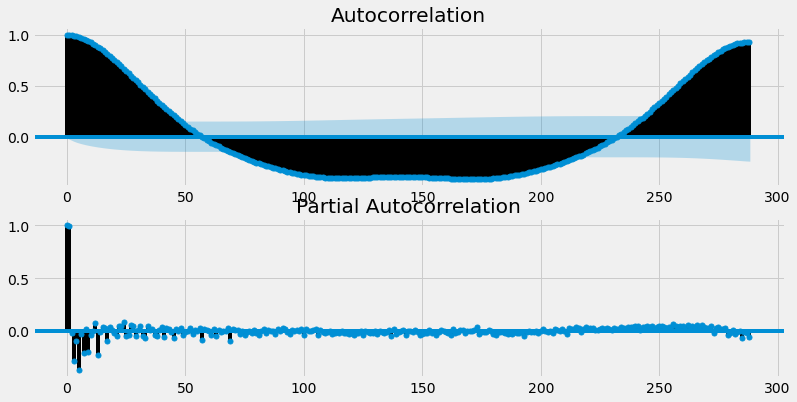

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(serie_train['total'], ax=ax[0], lags=day_samples)
ax[1] = plot_pacf(serie_train['total'], ax=ax[1], lags=day_samples)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



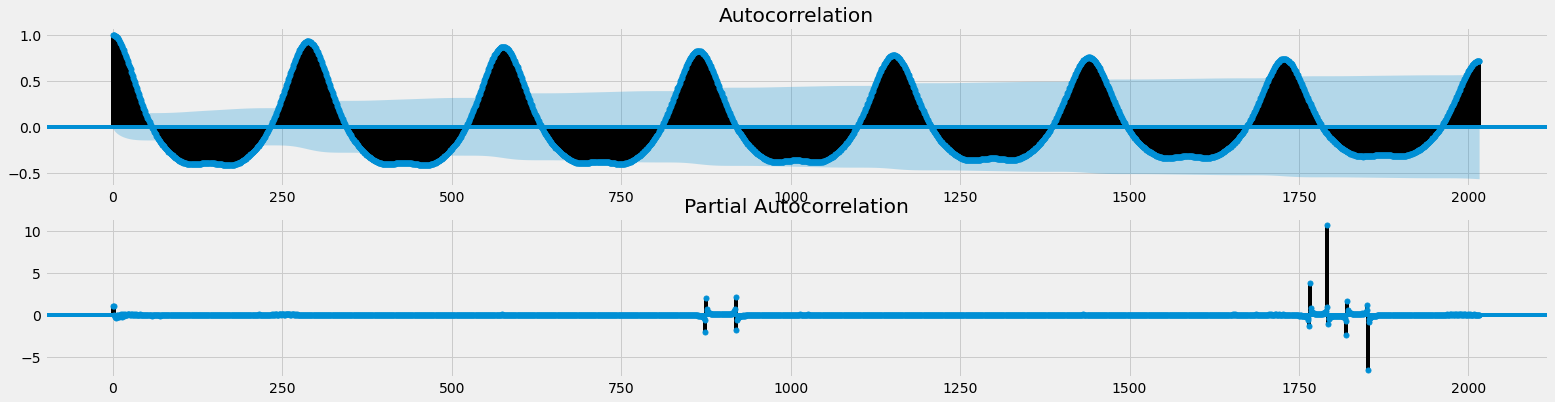

In [ ]:
fig, ax = plt.subplots(2, figsize=(24,6))
ax[0] = plot_acf(serie_train['total'], ax=ax[0], lags=week_samples)
ax[1] = plot_pacf(serie_train['total'], ax=ax[1], lags=week_samples)

##Estacionaridad

**KPSS**

The KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test tests for the null hypothesis that the series is trend stationary. In other words, if the p-value of the test statistic is below the X% confidence threshold, this means we can reject this hypothesis and that the series is not trend-stationary with X% confidence. A p-value higher than the threshold will lead us to accept this hypothesis and conclude that the series is trend-stationary.

In [ ]:
#lag=1 dia
statistic, p_value, n_lags, critical_values = kpss(serie_train['total'], lags=day_samples)
# Format Output
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
  print(f'   {key} : {value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 0.1619610204659851
p-value: 0.1
num lags: 288
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



In [ ]:
#lag=1 semana
statistic, p_value, n_lags, critical_values = kpss(serie_train['total'], lags=week_samples)
# Format Output
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
  print(f'   {key} : {value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 0.1799284528671933
p-value: 0.1
num lags: 2016
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



**Augmented Dickey-Fuller Test**

This test is used to assess whether or not a time-series is stationary. Without getting into too much details about hypothesis testing, you should know that this test will give a result called a “test-statistic”, based on which you can say, with different levels (or percentage) of confidence, if the time-series is stationary or not.

In [ ]:
dftest = adfuller(serie_train['total'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Test statistic = -10.155
P-value = 0.000
Critical values :
	1%: -3.4311649236856896 - The data is  stationary with 99% confidence
	5%: -2.861900138045498 - The data is  stationary with 95% confidence
	10%: -2.566961696766406 - The data is  stationary with 90% confidence
